## Kaggle "News Category" Dataset

### (For Colab) Mount Drive, check environment, and install packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [45]:
# Check GPU
!nvidia-smi

Wed May  6 14:03:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   4311MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-792rjgyy
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-792rjgyy
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=94a4818f211d527fd3cd29494e72b828b504669a26169adc434d5d348b3fdb4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-99n0ss8w/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
Requirement already up-to-date: mxnet-cu101mkl==1.6.0 in /usr/local/lib/python3.6/dist-packages (1.6.0)


In [46]:
# Verify MXNet detects GPU
import d2l
d2l.try_all_gpus()

# Should say [gpu(0)], NOT [cpu(0)]

[gpu(0)]

### Load data and encode labels

In [205]:
import pandas as pd
import numpy

# For local use
# newscat_raw = pd.read_json("./news-category-dataset/News_Category_Dataset_v2.json", lines = True)

# For Colab
newscat_raw = pd.read_json("/content/drive/My Drive/news-category-dataset/News_Category_Dataset_v2.json", lines = True)

newscat_raw.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [206]:
len(newscat_raw)

200853

In [207]:
# We have over 200k examples.
pd.value_counts(newscat_raw['category'])


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

There are 41 categories here, with as few as 1,004 examples (EDUCATION) and as many as 32,739 (POLITICS).

One oddity is that we have "WORLDPOST" and "THE WORLDPOST". It seems like this should be one combined category.

In [208]:
newscat_raw['category'] = newscat_raw['category'].str.replace("THE WORLDPOST", "WORLDPOST")
pd.value_counts(newscat_raw['category'])

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, dtype: int64

Now that we have combined "THE WORLDPOST" and "WORLDPOST" into a single category, we have 40 total categories. It's still not clear how, for example, WORLDPOST is different from WORLD NEWS.

In [209]:
# Check for missing values
newscat_raw.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [210]:
# This dataset is nice and clean! No null values to worry about!
# We have a headline, an author, and a short description to work with. Let's bring them all into one descriptor column

newscat_raw['full_description'] = newscat_raw[['authors','headline','short_description']].agg(' '.join, axis = 1)

# Maybe we shouldn't use the author (after discussion we will leave it in)
# newscat_raw['full_description'] = newscat_raw[['headline','short_description']].agg(' '.join, axis = 1)

newscat_raw.head()

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Ron Dicker Julianna Margulies Uses Donald Trum...


In [211]:
# Let's remove the stopwords from our data
# We'll use the stopwords list from the nltk corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [212]:
# Convert to string
newscat_raw['full_description'] = newscat_raw['full_description'].astype("string")

# Remove special characters
newscat_raw['full_description'] = newscat_raw['full_description'].str.replace(r'[^\w\s]+','') # Had to read up on Regex, but this finally got rid of punctuation! -JC

# Convert to lower, tokenize, and remove stop words
newscat_raw['full_description'] = newscat_raw['full_description'].str.lower().str.split()
newscat_raw['full_description'] = newscat_raw['full_description'].apply(lambda x: [item for item in x if item not in stop])
newscat_raw.head(10)

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,"[melissa, jeltsen, 2, mass, shootings, texas, ..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,"[andy, mcdonald, smith, joins, diplo, nicky, j..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,"[ron, dicker, hugh, grant, marries, first, tim..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,"[ron, dicker, jim, carrey, blasts, castrato, a..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,"[ron, dicker, julianna, margulies, uses, donal..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,"[ron, dicker, morgan, freeman, devastated, sex..."
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26,"[ron, dicker, donald, trump, lovin, new, mcdon..."
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26,"[todd, van, luling, watch, amazon, prime, that..."
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26,"[andy, mcdonald, mike, myers, reveals, hed, li..."
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26,"[todd, van, luling, watch, hulu, thats, new, w..."


(array([1.8480e+03, 1.7310e+04, 3.3858e+04, 5.2089e+04, 3.6183e+04,
        2.4527e+04, 1.5891e+04, 1.1609e+04, 5.3040e+03, 1.4040e+03,
        4.7700e+02, 1.0200e+02, 3.4000e+01, 2.7000e+01, 7.0000e+00,
        1.3000e+01, 2.4000e+01, 3.4000e+01, 3.2000e+01, 1.9000e+01,
        2.9000e+01, 1.0000e+01, 7.0000e+00, 6.0000e+00, 2.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ,  53.8,  58.6,  63.4,  68.2,  73. ,  77.8,  82.6,
         87.4,  92.2,  97. , 101.8, 106.6, 111.4, 116.2, 121. , 125.8,
        130.6, 135.4, 140.2, 145. ]),
 <a list of 30 Patch objects>)

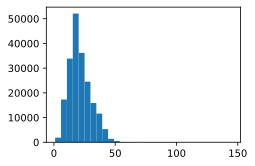

In [213]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(newscat_raw['full_description'].apply(len), bins=30)

We see here that if we fix our examples at 50 tokens, it will capture the vast majority of our examples in full.

In [214]:
# Now convert our text categories to panda categories for conversion to numeric labels
labels_raw = newscat_raw["category"].astype('category')
labels_raw["category"] = newscat_raw["category"].astype('category')
labels_raw.head()

0            CRIME
1    ENTERTAINMENT
2    ENTERTAINMENT
3    ENTERTAINMENT
4    ENTERTAINMENT
Name: category, dtype: object

In [215]:
labels_raw['catnum'] = labels_raw["category"].cat.codes
labels_raw['catnum']

0          6
1         10
2         10
3         10
4         10
          ..
200848    32
200849    28
200850    28
200851    28
200852    28
Length: 200853, dtype: int8

Create dictionary for going back and forth between codes and category names

In [216]:
category_dict = dict(enumerate(labels_raw["category"].cat.categories))
category_dict

{0: 'ARTS',
 1: 'ARTS & CULTURE',
 2: 'BLACK VOICES',
 3: 'BUSINESS',
 4: 'COLLEGE',
 5: 'COMEDY',
 6: 'CRIME',
 7: 'CULTURE & ARTS',
 8: 'DIVORCE',
 9: 'EDUCATION',
 10: 'ENTERTAINMENT',
 11: 'ENVIRONMENT',
 12: 'FIFTY',
 13: 'FOOD & DRINK',
 14: 'GOOD NEWS',
 15: 'GREEN',
 16: 'HEALTHY LIVING',
 17: 'HOME & LIVING',
 18: 'IMPACT',
 19: 'LATINO VOICES',
 20: 'MEDIA',
 21: 'MONEY',
 22: 'PARENTING',
 23: 'PARENTS',
 24: 'POLITICS',
 25: 'QUEER VOICES',
 26: 'RELIGION',
 27: 'SCIENCE',
 28: 'SPORTS',
 29: 'STYLE',
 30: 'STYLE & BEAUTY',
 31: 'TASTE',
 32: 'TECH',
 33: 'TRAVEL',
 34: 'WEDDINGS',
 35: 'WEIRD NEWS',
 36: 'WELLNESS',
 37: 'WOMEN',
 38: 'WORLD NEWS',
 39: 'WORLDPOST'}

### Partition into train, validate, and test

In [0]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import numpy
import random
npx.set_np()

In [218]:
# Partition into training, validation, and test
train_pct = .8
validation_pct = .1
# Test set will be remainder of examples

num_examples = len(labels_raw['catnum'])
rownums = list(range(num_examples))

random.seed(1729) # Set seed so test data doesn't leak across multiple sessions
random.shuffle(rownums)

train_examples = int(num_examples * train_pct)
validation_examples = int(num_examples * validation_pct)

trainsetnums = rownums[:train_examples]
validsetnums = rownums[train_examples: train_examples + validation_examples]
testsetnums = rownums[train_examples + validation_examples: ]

print("Train/Validate/Test count: ", len(trainsetnums), len(validsetnums), len(testsetnums))

Train/Validate/Test count:  160682 20085 20086


In [0]:
Examples_train = list(newscat_raw['full_description'][trainsetnums])
Examples_validation = list(newscat_raw['full_description'][validsetnums])
Examples_test = list(newscat_raw['full_description'][testsetnums])

train_labels = list(labels_raw['catnum'][trainsetnums])
validation_labels = list(labels_raw['catnum'][validsetnums])
test_labels = list(labels_raw['catnum'][testsetnums])

In [220]:
y_train = np.array(labels_raw['catnum'][trainsetnums], dtype = np.float32).reshape(-1, 1)
y_validation = np.array(labels_raw['catnum'][validsetnums], dtype = np.float32).reshape(-1, 1)
y_test = np.array(labels_raw['catnum'][testsetnums], dtype = np.float32).reshape(-1, 1)

print(y_train.shape, len(Examples_train))
print(y_validation.shape, len(Examples_validation))
print(y_test.shape, len(Examples_test))

(160682, 1) 160682
(20085, 1) 20085
(20086, 1) 20086


In [0]:

### We changed our text preprocessing so our examples are already split into words above.
 

#  def tokenize(lines, token='word'):
#     if token == 'word':
#         return [line.split(' ') for line in lines]
#     elif token == 'char':
#         return [list(line) for line in lines]
#     else:
#         print('ERROR: unknown token type '+token)
        
# train_tokens = tokenize(Examples_train, token = 'word')
# validation_tokens = tokenize(Examples_validation, token = 'word')
# test_tokens = tokenize(Examples_test, token = 'word')


train_tokens = Examples_train
validation_tokens = Examples_validation
test_tokens = Examples_test

Let's look at some random examples from the training data to see if our headlines and categories make sense.

In [225]:
example_num = random.randint(0,len(trainsetnums))
print(train_tokens[example_num])
print(category_dict.get(int(y_train[example_num])))

['nbc', 'found', 'time', 'ask', 'bill', 'clintons', 'sex', 'life', 'hillary', 'clintons', 'new', 'defense', 'abortion', 'rights', 'longer', 'comes', 'news', 'democratic', 'party', 'committed', 'political', 'malpractice', 'making', 'primary', 'debates']
WOMEN


### Word Embeddings

We'll use the `Vocab` function defined in D2L 8.2.

In [0]:
# TODO(JC): I'm trying to avoid calling the d2l package directly, but I'm having a hard time  
#           adapting the Vocab function from the version defined in d2l 8.2.
#           UPDATE: Given time constraints, let's just keep the d2l function here. 

import d2l
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>']) 

In [227]:
print(vocab.token_freqs[:20]) # Check the most frequent words. Stop words and special characters have been removed.


[('contributor', 30484), ('new', 15867), ('one', 12643), ('us', 12048), ('trump', 10797), ('time', 9736), ('people', 9640), ('like', 9297), ('author', 9109), ('photos', 9001), ('day', 8420), ('life', 7895), ('get', 7613), ('make', 7282), ('world', 6741), ('first', 6523), ('writer', 6380), ('dont', 6337), ('best', 6068), ('know', 6035)]


In [228]:
# Load pre-trained GloVe word embedding. This is available as a resource in mxnet. 
# We'll follow d2l's lead and use the 100d version
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

# Check the dimentions of our embeddings (should be vocab size x dimensionality of embedding we chose)
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

### Data iterator

In [229]:
num_steps = 50  # Sequence length. We saw above that 50 should be plenty.
train_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

validation_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in validation_tokens])
print(validation_features.shape)

test_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
print(test_features.shape)


(160682, 50)
(20085, 50)
(20086, 50)


In [0]:
X_train = np.array(train_features, dtype = np.float32)
X_validation = np.array(validation_features, dtype = np.float32)
X_test = np.array(test_features, dtype = np.float32)

In [231]:
batch_size = 128
train_iter = d2l.load_array((train_features, train_labels), batch_size)   ###JC: Another invocation of d2l library
validation_iter = d2l.load_array((validation_features, validation_labels), batch_size, is_train = False)   
test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)   


for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (128, 50) y (128,)


('# batches:', 1256)

### Training Loop

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, batch_size, ctx=d2l.try_gpu()):
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  train_ls, train_acc, test_acc = [], [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)
  trainer = gluon.Trainer(net.collect_params(),
                              'adam', {'learning_rate': lr})
  
  for epoch in range(num_epochs):
    train_acc_minibatch = []
    train_ls_minibatch = []
    test_acc_minibatch = []
    for i, (X, y) in enumerate(train_iter):
      X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat, y)
      l.backward()
      # print("Minibatch Completed")
      if(len(y) == batch_size): # Only calculate on full minibatches
        train_accuracy = (net(X).argmax(axis = 1).reshape(-1, 1) == 
                          y).sum()/len(y)
        train_loss = loss(net(X), y).mean()
        train_acc_minibatch.append(train_accuracy)
        train_ls_minibatch.append(train_loss)
      # print(train_accuracy)
      trainer.step(batch_size)

    # Validation set is too large to evaluate all at once.
    # Loop to evaluate test accuracy in minibatches.
    for i, (Xtest, ytest) in enumerate(test_iter):
      Xtest, ytest = Xtest.as_in_ctx(ctx), ytest.as_in_ctx(ctx)
      if(len(ytest) == batch_size): # Only calculate on full minibatches
        test_accuracy = (net(Xtest).argmax(axis = 1).reshape(-1, 1) == 
                          ytest).sum()/len(ytest)
        test_acc_minibatch.append(test_accuracy)


    train_acc.append(np.array(train_acc_minibatch).mean())
    test_acc.append(np.array(test_acc_minibatch).mean())
    train_ls.append(np.array(train_ls_minibatch).mean())
    print("Epoch = %d: Train acc: %f, Test acc: = %f" % (epoch, train_acc[-1], test_acc[-1]))
  return train_ls, train_acc, test_acc

### Bi-LSTM: First and last timesteps connected

This is the presentation found in d2l, with only the first and last timesteps connected to the output dense layer

In [0]:
# BiRNN Block from d2l 15.2

class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [351]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.655783, Test acc: = 0.720753
Epoch = 1: Train acc: 0.743800, Test acc: = 0.739533
Epoch = 2: Train acc: 0.763633, Test acc: = 0.739483
Epoch = 3: Train acc: 0.776301, Test acc: = 0.748297
Epoch = 4: Train acc: 0.783927, Test acc: = 0.747947
Epoch = 5: Train acc: 0.789442, Test acc: = 0.748397
Epoch = 6: Train acc: 0.781312, Test acc: = 0.728616
Epoch = 7: Train acc: 0.768769, Test acc: = 0.744541
Epoch = 8: Train acc: 0.785427, Test acc: = 0.744141
Epoch = 9: Train acc: 0.791104, Test acc: = 0.744842
Training time 411.36092 sec
Training loss: 0.695743
Train accuracy: 0.791104
Validation accuracy: 0.744842


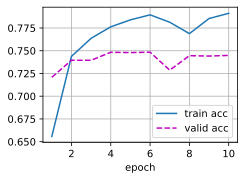

In [352]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

In [353]:
# Look at random validation examples, their actual categories, and their predicted categories

example_num = random.randint(0,len(validation_labels))
pred_example = np.array(validation_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(validation_tokens[example_num])
print("Actual: ", category_dict.get(int(y_validation[example_num])))
print("Predicted: ", pred_cat)

['oystercom', 'contributor', 'hotel', 'tellall', 'folks', 'hotel', 'ads', 'terrifyingly', 'happy', 'photos', 'hotel', 'websites', 'go', 'little', 'far', 'market', 'properties', 'showing', 'guests', 'absolutely', 'euphoric', 'state', 'seem', 'taking', 'recreational', 'drugs', 'handfull']
Actual:  TRAVEL
Predicted:  TRAVEL


### Bi-LSTM: All time steps connected to Dense Layer

Now we try modifying the structure by connecting all 50 timesteps to the dense layer.

In [0]:

class DenseBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(DenseBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        outs = self.decoder(outputs)
        return outs

In [355]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = DenseBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.669161, Test acc: = 0.726562
Epoch = 1: Train acc: 0.757451, Test acc: = 0.746044
Epoch = 2: Train acc: 0.788278, Test acc: = 0.747646
Epoch = 3: Train acc: 0.811211, Test acc: = 0.749399
Epoch = 4: Train acc: 0.831960, Test acc: = 0.745843
Epoch = 5: Train acc: 0.849956, Test acc: = 0.740986
Epoch = 6: Train acc: 0.866409, Test acc: = 0.743189
Epoch = 7: Train acc: 0.879880, Test acc: = 0.740986
Epoch = 8: Train acc: 0.891272, Test acc: = 0.736078
Epoch = 9: Train acc: 0.902079, Test acc: = 0.737580
Training time 421.36476 sec
Training loss: 0.307257
Train accuracy: 0.902079
Validation accuracy: 0.737580


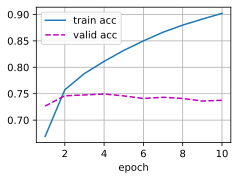

In [356]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### Bi-LSTM plus Max-Pooling Layer
Rather than directly connecting all 50 timesteps to the dense layer, we first apply a Max Pooling layer.

In [0]:
class MaxPoolBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(MaxPoolBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        # self.conv1 = nn.Conv1D(channels = 40, kernel_size = 3, padding= 1,
                              #  layout = 'NCW')
        self.maxpool = nn.MaxPool1D(pool_size = 5, strides = 5, layout = 'NCW')
        # self.gapool = nn.GlobalAvgPool1D(layout = 'NCW')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # hidden_1 = self.conv1(outputs)
        hidden_1 = self.maxpool(outputs)
        # print(outputs.shape)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        # encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        # encoding = np.concatenate((outputs), axis=2)  # Keep all timesteps
        outs = self.decoder(hidden_1)
        return outs

In [360]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = MaxPoolBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.665289, Test acc: = 0.724559
Epoch = 1: Train acc: 0.750996, Test acc: = 0.733924
Epoch = 2: Train acc: 0.774440, Test acc: = 0.741737
Epoch = 3: Train acc: 0.789473, Test acc: = 0.743139
Epoch = 4: Train acc: 0.801675, Test acc: = 0.745242
Epoch = 5: Train acc: 0.810738, Test acc: = 0.740335
Epoch = 6: Train acc: 0.819161, Test acc: = 0.740785
Epoch = 7: Train acc: 0.826525, Test acc: = 0.741587
Epoch = 8: Train acc: 0.832470, Test acc: = 0.736679
Epoch = 9: Train acc: 0.839710, Test acc: = 0.738832
Training time 422.58465 sec
Training loss: 0.517358
Train accuracy: 0.839710
Validation accuracy: 0.738832


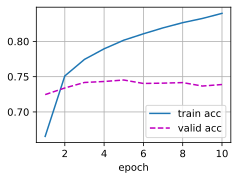

In [361]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

In [363]:
# Look at random validation examples, their actual categories, and their predicted categories

example_num = random.randint(0,len(validation_labels))
pred_example = np.array(validation_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(validation_tokens[example_num])
print("Actual: ", category_dict.get(int(y_validation[example_num])))
print("Predicted: ", pred_cat)

['sasha', 'bronner', '9', 'things', 'learned', 'year', 'first', 'dates', 'online', 'dating', 'taught', 'men']
Actual:  WOMEN
Predicted:  WOMEN


### Bi-LSTM with Avg Pooling Layer

Now we replace the Max Pooling layer with Average Pooling

In [0]:
class AvgPoolBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(AvgPoolBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.avgpool = nn.AvgPool1D(pool_size = 5, strides = 5, layout = 'NCW')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        hidden_1 = self.avgpool(outputs)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        outs = self.decoder(hidden_1)
        return outs

In [366]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = AvgPoolBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.677310, Test acc: = 0.728616
Epoch = 1: Train acc: 0.759450, Test acc: = 0.743139
Epoch = 2: Train acc: 0.776874, Test acc: = 0.743239
Epoch = 3: Train acc: 0.788894, Test acc: = 0.743289
Epoch = 4: Train acc: 0.798680, Test acc: = 0.746144
Epoch = 5: Train acc: 0.806810, Test acc: = 0.745793
Epoch = 6: Train acc: 0.809437, Test acc: = 0.741086
Epoch = 7: Train acc: 0.818364, Test acc: = 0.742788
Epoch = 8: Train acc: 0.821327, Test acc: = 0.741787
Epoch = 9: Train acc: 0.826133, Test acc: = 0.747196
Training time 424.20694 sec
Training loss: 0.559822
Train accuracy: 0.826133
Validation accuracy: 0.747196


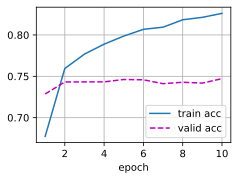

In [367]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### Bi-LSTM + Global Average Pooling

Instead of a narrow pooling window, we try Global Average Pooling

In [0]:
class GAPBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(GAPBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.avgpool = nn.GlobalAvgPool1D(layout = 'NCW')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        hidden_1 = self.avgpool(outputs)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        outs = self.decoder(hidden_1)
        return outs

In [369]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = GAPBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.454694, Test acc: = 0.583183
Epoch = 1: Train acc: 0.540351, Test acc: = 0.542468
Epoch = 2: Train acc: 0.537307, Test acc: = 0.462991
Epoch = 3: Train acc: 0.497504, Test acc: = 0.531150
Epoch = 4: Train acc: 0.544248, Test acc: = 0.547927
Epoch = 5: Train acc: 0.501164, Test acc: = 0.356520
Epoch = 6: Train acc: 0.357968, Test acc: = 0.384515
Epoch = 7: Train acc: 0.336274, Test acc: = 0.322766
Epoch = 8: Train acc: 0.341783, Test acc: = 0.356470
Epoch = 9: Train acc: 0.367082, Test acc: = 0.358724
Training time 424.41201 sec
Training loss: 2.336286
Train accuracy: 0.367082
Validation accuracy: 0.358724


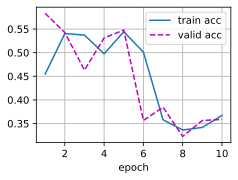

In [370]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### Bi-LSTM + Conv and Pooling

In [0]:
class ConvBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(ConvBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.conv1 = nn.Conv1D(channels = 40, kernel_size = 3, padding= 1,
                               layout = 'NCW')
        self.maxpool = nn.MaxPool1D(pool_size = 5, strides = 5, layout = 'NCW')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        hidden_1 = self.conv1(outputs)
        hidden_2 = self.maxpool(hidden_1)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
  
        outs = self.decoder(hidden_2)
        return outs

In [372]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = ConvBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.669460, Test acc: = 0.719601
Epoch = 1: Train acc: 0.744030, Test acc: = 0.736679
Epoch = 2: Train acc: 0.762444, Test acc: = 0.744541
Epoch = 3: Train acc: 0.773662, Test acc: = 0.747196
Epoch = 4: Train acc: 0.782557, Test acc: = 0.749199
Epoch = 5: Train acc: 0.789299, Test acc: = 0.746795
Epoch = 6: Train acc: 0.795761, Test acc: = 0.750351
Epoch = 7: Train acc: 0.802434, Test acc: = 0.750451
Epoch = 8: Train acc: 0.807949, Test acc: = 0.744691
Epoch = 9: Train acc: 0.811653, Test acc: = 0.747045
Training time 448.40243 sec
Training loss: 0.623919
Train accuracy: 0.811653
Validation accuracy: 0.747045


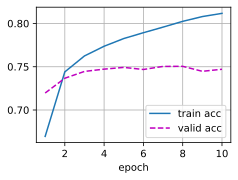

In [373]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])

### ConvNet feeding into bi-LSTM

In [0]:
class ConvPreBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(ConvPreBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.conv1 = nn.Conv1D(channels = 50, kernel_size = 3, padding= 1,
                               layout = 'NCW')
        self.maxpool = nn.MaxPool1D(pool_size = 3, strides = 1, layout = 'NCW', 
                                    padding = 1)
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        hidden_1 = self.conv1(embeddings)
        hidden_2 = self.maxpool(hidden_1)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(hidden_2)
        # hidden_1 = self.conv1(outputs)
        # hidden_2 = self.maxpool(hidden_1)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
  
        outs = self.decoder(outputs)
        return outs

In [378]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = ConvPreBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(37208, 100)

Epoch = 0: Train acc: 0.371614, Test acc: = 0.464343
Epoch = 1: Train acc: 0.518227, Test acc: = 0.507562
Epoch = 2: Train acc: 0.558777, Test acc: = 0.562700
Epoch = 3: Train acc: 0.569447, Test acc: = 0.569912
Epoch = 4: Train acc: 0.568289, Test acc: = 0.566657
Epoch = 5: Train acc: 0.568626, Test acc: = 0.563752
Epoch = 6: Train acc: 0.574832, Test acc: = 0.570513
Epoch = 7: Train acc: 0.572379, Test acc: = 0.569411
Epoch = 8: Train acc: 0.577428, Test acc: = 0.569211
Epoch = 9: Train acc: 0.581119, Test acc: = 0.573067
Epoch = 10: Train acc: 0.580391, Test acc: = 0.573968
Epoch = 11: Train acc: 0.582097, Test acc: = 0.579377
Epoch = 12: Train acc: 0.584387, Test acc: = 0.581030
Epoch = 13: Train acc: 0.577428, Test acc: = 0.576422
Epoch = 14: Train acc: 0.579015, Test acc: = 0.579026
Epoch = 15: Train acc: 0.584138, Test acc: = 0.579026
Epoch = 16: Train acc: 0.583510, Test acc: = 0.581480
Epoch = 17: Train acc: 0.586348, Test acc: = 0.586038
Epoch = 18: Train acc: 0.590868, Test 

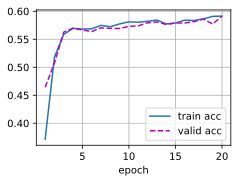

In [379]:
lr, num_epochs, batch_size = 0.02, 20, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'valid acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Validation accuracy: %f" % test_acc[-1])